### Use Python H2O.ai AutoML to build a model and deploy it with KNIME MOJO nodes


<img src="../KNIME_loves_h2o.png" width="600">


##### KNIME workflow
https://hub.knime.com/-/spaces/-/latest/~GABT_OgeoWxWJW9P/


##### GitHub: A small collection of Jupyter Notebooks to solve CLASSIFICATION tasks

https://github.com/ml-score/knime_meets_python/tree/main/machine_learning/binary

##### Medium Blog: KNIME — Machine Learning and Artificial Intelligence— A Collection

https://medium.com/p/12e0f7d83b50

##### Medium Blog: About Machine-Learning — How it Fails and Succeeds

https://medium.com/p/9f3ab7cb9b00

###### additional links and texts

https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html

https://medium.com/dataman-in-ai/the-shap-values-with-h2o-models-773a203b75e3


PLEASE note: auto-machine-learning might benefit from longer trainig time so adapt the setting "**max_runtime_secs_opts**" accoringly. To test if the notebook works these has been set to just afew minutes. You might want to let it run for several hours (or even days) depending on your task and the restults.

Also you might want to inspect the other settings about algorithms and metrics (AUC, AUCP, LogLoss ...)

There is also a notebook to collect and inspect the results of the models you have created The parameters will be stored in JSON files so you can collect and compare them:

**kn_example_python_h2o_automl_inspect_models.ipynb**

#### 001 - setup python libraries

In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import json

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, auc, average_precision_score, precision_recall_curve

In [3]:
# provide a software like h2o with a java path using KNIME's own java version
# variable java.home from KNIME

# https://hub.knime.com/-/spaces/-/latest/~SGv1Cosah8BXabfa/

# KNIME Snippets (2): Unearthing Hidden Node Gems — Managing Missing Values, Row Numbers and some Quick Java and Paths
# https://medium.com/p/3c3c7acb019f

import os;

# your own Java path might look different obviously :-) - check the link and the Medium article about how to find it

# os.environ["JAVA_HOME"] = "C:\\Users\\x123456789\\software\\knime_4.6.1\\plugins\\org.knime.binary.jre.win32.x86_64_17.0.3.20220621\\jre"

os.environ["JAVA_HOME"] = "/Applications/KNIME 4.7.1.app/Contents/Eclipse/plugins/org.knime.binary.jre.macosx.aarch64_17.0.5.20230320/jre/Contents/Home"


print("setenv JAVA_HOME", os.environ["JAVA_HOME"])

setenv JAVA_HOME /Applications/KNIME 4.7.1.app/Contents/Eclipse/plugins/org.knime.binary.jre.macosx.aarch64_17.0.5.20230320/jre/Contents/Home


In [4]:
# initiate h2o
# pip uninstall h2o
# if it is already running it will cconnect to the running cluster
# # pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

# conda install -c h2oai h2o

import h2o

from h2o.automl import H2OAutoML

h2o.init()

# under Windows there might be a problem with the progress bar - so you could just turn it off
# https://forum.knime.com/t/python-script-and-h2o-data-frames-error-under-windows/21099/4?u=mlauber71
# h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.5" 2022-10-18; OpenJDK Runtime Environment Temurin-17.0.5+8 (build 17.0.5+8); OpenJDK 64-Bit Server VM Temurin-17.0.5+8 (build 17.0.5+8, mixed mode)
  Starting server from /opt/homebrew/Caskroom/miniforge/base/envs/py3_knime_lightgbm/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/db/_t7vx7_570q0n3bs1f643nfc0000gn/T/tmpso30oj2o
  JVM stdout: /var/folders/db/_t7vx7_570q0n3bs1f643nfc0000gn/T/tmpso30oj2o/h2o_m_lauber_started_from_python.out
  JVM stderr: /var/folders/db/_t7vx7_570q0n3bs1f643nfc0000gn/T/tmpso30oj2o/h2o_m_lauber_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_m_lauber_bsubix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [5]:
# the flow_variables<..> are there if you want to use the code from within KNIME
# and privide the information via (well) Flow Variables

# http://strftime.org'
import time
var_timestamp_day = "{}".format(time.strftime("%Y%m%d"))
# flow_variables['var_timestamp_day'] = var_timestamp_day
print("var_timestamp_day: ", var_timestamp_day)

var_timestamp_time = "{}h".format(time.strftime("%H%M"))
# flow_variables['var_timestamp_time'] = var_timestamp_time
print("var_timestamp_time: ", var_timestamp_time)

# _edit: if you want to have another model name
var_model_name = "H2O_AutoML_Classification"
# flow_variables['var_model_name'] = var_model_name

var_model_name_full = var_model_name + "_" + var_timestamp_day  + "_" + var_timestamp_time + "_jupyter"
# flow_variables['var_model_name_full'] = var_model_name_full
print("var_model_name_full: ", var_model_name_full)

# if you do not want to store the files in the working directory
var_path_data = "../"
var_path_model = "../model/"

var_timestamp_day:  20230603
var_timestamp_time:  1116h
var_model_name_full:  H2O_AutoML_Classification_20230603_1116h_jupyter


The data used has beed adapted from:

**Census Income Data Set**

Abstract: Predict whether income exceeds $50K/yr based on census data. Also known as "Adult" dataset.

Extract and prepare the Census Income Files for usage in KNIME

https://archive.ics.uci.edu/ml/datasets/census+income

In [6]:
data      = pq.read_table(var_path_data + "train.parquet").to_pandas()
data_test = pq.read_table(var_path_data + "test.parquet").to_pandas()

In [20]:
excluded_features = ['row_id']
label = 'Target'  # label is a simple string

features = [feat for feat in data.columns if feat not in excluded_features and feat != label]  # change "not in" to "!="

num_cols = data[features].select_dtypes(include='number').columns.tolist()
cat_cols = data[features].select_dtypes(exclude='number').columns.tolist()

rest_cols = [feat for feat in data.columns if feat not in cat_cols]

# store the features plus the labels in a list
features_plus_label = features.copy()  # use copy() to prevent modifying original list
features_plus_label.append(label)  # use append() as label is a simple string

print(f'''{"data shape:":20} {data.shape}
{"data[features] shape:":20} {data[features].shape}
categorical columns: {cat_cols}
numerical columns: {num_cols}
feature columns: {features}
feature plus Label columns: {features_plus_label}
rest columns: {rest_cols}''')


data shape:          (34189, 16)
data[features] shape: (34189, 14)
categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numerical columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
feature columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
feature plus Label columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Target']
rest columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id']


In [13]:
print(data.dtypes)

age                int32
workclass         object
fnlwgt             int32
education         object
education-num      int32
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int32
capital-loss       int32
hours-per-week     int32
native-country    object
Target            object
row_id            object
dtype: object


In [14]:
print(features_plus_label)

['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Target']


In [ ]:
# data[cat_cols] = data[cat_cols].astype('category')

In [15]:
# split test and training data
train_df, valid_df = train_test_split(data[features_plus_label], test_size=0.3, random_state=42)

In [16]:
# import the df data into H2O data system
train = h2o.H2OFrame(train_df.copy())
valid = h2o.H2OFrame(valid_df.copy())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [17]:
# if it is a classification task make sure the Target is a factor
train[label] = train[label].asfactor()
valid[label] = valid[label].asfactor()

In [ ]:
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/sort_metric.html
# http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html

# Run AutoML for 60 seconds or
# 300 = 5 min, 600 = 10 min, 900 = 15 min, 1800 = 30 min, 3600 = 1 hour, 
# 7200 = 2 hours
# 14400 = 4 hours
# 16200 = 4.5 hours
# 18000 = 5 Stunden
# 21600 = 6 hours
# 25200 = 7 hours
# 28800 = 8 hours
# 36000 = 10 hours

# _edit: get the maximum runtime from the KNIME workflow
max_runtime_secs_opts = 120

import time
import datetime as dt
from datetime import date

var_now = dt.datetime.now()

var_startmodel_day = "{}".format(var_now.strftime("%Y%m%d"))
print("var_startmodel_day: ", var_timestamp_day)
var_startmodel_time = "{}h".format(var_now.strftime("%H%M"))
print("var_startmodel_time: ", var_timestamp_time)

# based on the set runtime print the end time
v_endtime = var_now + dt.timedelta(seconds=max_runtime_secs_opts)

var_endmodel_day = "{}".format(v_endtime.strftime("%Y%m%d"))
print("var_endmodel_day: ", var_endmodel_day)
var_endmodel_time = "{}h".format(v_endtime.strftime("%H%M"))
print("var_endmodel_time: ", var_endmodel_time)

# you could exclude algorithms as they might not be suitable eg. for export as MOJO files
# or to be used in Big Data environments
# exclude_algos      =["GBM", "GLM", "DeepLearning", "DRF", "StackedEnsemble", "XGBoost"]

# For binomial classification choose between "AUC", "logloss", "mean_per_class_error", "RMSE", "MSE". 
# For multinomial classification choose between "mean_per_class_error", "logloss", "RMSE", "MSE". 
# For regression choose between "deviance", "RMSE", "MSE", "MAE", "RMLSE".

aml = H2OAutoML(max_runtime_secs  = max_runtime_secs_opts, 
                seed               =1234, 
                sort_metric        ="AUCPR",
                stopping_metric    ="AUCPR",
                stopping_tolerance =0.01,
                stopping_rounds    =25,
                project_name       =var_model_name_full ,
                # exclude_algos      =["GBM", "GLM", "DeepLearning", "DRF", "StackedEnsemble"]  #,
                # exclude_algos      =["DRF", "GLM"] 
                # exclude_algos      =["DeepLearning", "StackedEnsemble", "XGBoost"] 
                exclude_algos      =["StackedEnsemble"] 
               )

# x - all our variables we want to use to explain the:
# y - Target Variable - in this case "Target"
aml.train(x = features, y = label,  
          training_frame   = train,  
          validation_frame = valid)  

In [22]:
# View the AutoML Leaderboard
lb = aml.leaderboard
tb_leaderboard = lb.as_data_frame(use_pandas=True, header=True)
print(lb)

model_id                                         aucpr       auc    logloss    mean_per_class_error      rmse        mse
GBM_grid_1_AutoML_1_20230603_113003_model_6   0.820017  0.923073   0.287269                0.172811  0.301745  0.0910502
GBM_grid_1_AutoML_1_20230603_113003_model_5   0.819762  0.9229     0.288061                0.174143  0.301669  0.0910044
GBM_grid_1_AutoML_1_20230603_113003_model_8   0.819234  0.922578   0.288413                0.170471  0.302132  0.0912839
GBM_grid_1_AutoML_1_20230603_113003_model_2   0.818836  0.922732   0.288707                0.178821  0.302133  0.0912844
GBM_5_AutoML_1_20230603_113003                0.817689  0.922865   0.289078                0.169807  0.302271  0.0913677
GBM_grid_1_AutoML_1_20230603_113003_model_10  0.817216  0.922691   0.290144                0.170409  0.303163  0.0919076
GBM_2_AutoML_1_20230603_113003                0.81622   0.92115    0.291676                0.172871  0.303779  0.0922819
GBM_grid_1_AutoML_1_20230603_113

In [23]:
# you can change the automatic choice and name a variable from the leader board
# var_selected_model = "GBM_1_AutoML_20191214_123545"
var_selected_model = aml.leader.model_id
print("var_selected_model :", var_selected_model)

# flow_variables['var_selected_model'] = var_selected_model

# get the extracted model
best_model = h2o.get_model(var_selected_model)
best_params = best_model.actual_params

var_selected_model : GBM_grid_1_AutoML_1_20230603_113003_model_6


In [24]:
# show the best parameters
print(best_params)

{'model_id': 'GBM_grid_1_AutoML_1_20230603_113003_model_6', 'training_frame': 'AutoML_1_20230603_113003_training_py_1_sid_9501', 'validation_frame': 'py_2_sid_9501', 'nfolds': 5, 'keep_cross_validation_models': False, 'keep_cross_validation_predictions': True, 'keep_cross_validation_fold_assignment': False, 'score_each_iteration': False, 'score_tree_interval': 5, 'fold_assignment': 'Modulo', 'fold_column': None, 'response_column': 'Target', 'ignored_columns': [], 'ignore_const_cols': True, 'offset_column': None, 'weights_column': None, 'balance_classes': False, 'class_sampling_factors': None, 'max_after_balance_size': 5.0, 'max_confusion_matrix_size': 20, 'ntrees': 153, 'max_depth': 7, 'min_rows': 30.0, 'nbins': 20, 'nbins_top_level': 1024, 'nbins_cats': 1024, 'r2_stopping': 1.7976931348623157e+308, 'stopping_rounds': 0, 'stopping_metric': 'AUCPR', 'stopping_tolerance': 0.01, 'max_runtime_secs': 32.03375, 'seed': 1239, 'build_tree_one_node': False, 'learn_rate': 0.1, 'learn_rate_anneal

In [25]:
# evaluate the best model on the test data
y_pred = best_model.predict(valid).as_data_frame()

# evaluate the initial values based on the (internal Test data)
auc_pred = roc_auc_score(valid_df[label], y_pred['p1'], average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

aucpr = average_precision_score(valid_df[label], y_pred['p1'], average='weighted', pos_label='1')
print(f'Test AUCPR: {aucpr:.4f}')

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Test AUC: 0.9271
Test AUCPR: 0.8208


In [26]:
# save the model as MOJO which you could read back in with KNIME
var_mojo_file_name = var_path_model + var_model_name_full + "_model_stored.zip"
# flow_variables['var_mojo_file_name'] = var_mojo_file_name
print("var_mojo_file_name: ", var_mojo_file_name)

# reload the saved MOJO model
best_model.download_mojo(var_mojo_file_name)

var_mojo_file_name:  ../model/H2O_AutoML_Classification_20230603_1116h_jupyter_model_stored.zip


'/Users/m_lauber/Dropbox/knime-workspace/Machine_Learning/ml_binary/kn_example_ml_binary_lightgbm_hyper_parameter_opt/data/model/H2O_AutoML_Classification_20230603_1116h_jupyter_model_stored.zip'

In [27]:
# store the variales list as dictionary in a JSON file to read back later

v_variable_list = {
    "var_model_name": var_model_name,
    "var_model_name_full": var_model_name_full,
    "num_cols": num_cols,
    "cat_cols": cat_cols,
    "rest_cols": rest_cols,
    "label": label,
    "features": features,
    "excluded_features": excluded_features,
    "Test_AUC": f'{auc_pred:.5f}',
    "Test_AUCPR": f'{aucpr:.5f}'
}

In [28]:
print(v_variable_list)

{'var_model_name': 'H2O_AutoML_Classification', 'var_model_name_full': 'H2O_AutoML_Classification_20230603_1116h_jupyter', 'num_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], 'cat_cols': ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], 'rest_cols': ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'Target', 'row_id'], 'label': 'Target', 'features': ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], 'excluded_features': ['row_id'], 'Test_AUC': '0.92714', 'Test_AUCPR': '0.82083'}


In [29]:
type(v_variable_list)

dict

In [30]:
# Write the dictionary to a JSON file
with open(var_path_model + var_model_name_full + "_variable_list.json", "w") as f:
    json.dump(v_variable_list, f)

In [31]:
# show the best parameters
best_parameters = best_model.params
print(best_parameters)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_grid_1_AutoML_1_20230603_113003_model_6', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_grid_1_AutoML_1_20230603_113003_model_6'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20230603_113003_training_py_1_sid_9501', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20230603_113003_training_py_1_sid_9501'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20230603_113003_training_py_1_sid_9501', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20230603_113003_training_py_1_sid_9501'}}, 'validation_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'py_2_sid_9501', 'typ

In [32]:
with open(var_path_model + var_model_name_full + "_model_parameters.txt", "w") as file:
    print(best_parameters, file=file)

In [33]:
df_best_parameters = pd.read_csv(var_path_model + var_model_name_full + "_model_parameters.txt", sep = "@",header = None, names=["lgbm_parameters"])

In [34]:
df_best_parameters.head()

,lgbm_parameters
0,"{'model_id': {'default': None, 'actual': {'__m..."


In [35]:
# extract important tables from model to store later
feature_imp = best_model._model_json['output']['variable_importances'].as_data_frame()

In [36]:
feature_imp.head(25)

,variable,relative_importance,scaled_importance,percentage
0,marital-status,2549.083984,1.000000,0.205226
1,capital-gain,2286.684082,0.897061,0.184100
2,relationship,1458.146240,0.572028,0.117395
3,education,1200.265625,0.470862,0.096633
4,age,853.418274,0.334794,0.068708
5,education-num,826.911255,0.324395,0.066574
6,occupation,802.200073,0.314701,0.064585
7,capital-loss,777.970886,0.305196,0.062634
8,hours-per-week,555.195190,0.217802,0.044699
9,workclass,313.567963,0.123012,0.025245


In [37]:
feature_imp.to_parquet(var_path_model + var_model_name_full + "_feature_importance.parquet", compression='gzip')

### Export the Gains-Lift Table to decide what to do with you model

In [38]:
gains_lift_table = best_model.gains_lift()
avg_response_rate_df = gains_lift_table.as_data_frame()
avg_response_rate_df.head(25)

,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010028,0.996023,4.149818,4.149818,1.000000,0.997140,1.000000,0.997140,0.041616,0.041616,314.981793,314.981793,0.041616
1,2,0.020015,0.993513,4.149818,4.149818,1.000000,0.994861,1.000000,0.996003,0.041443,0.083059,314.981793,314.981793,0.083059
2,3,0.030002,0.988919,4.149818,4.149818,1.000000,0.991312,1.000000,0.994441,0.041443,0.124501,314.981793,314.981793,0.124501
3,4,0.040030,0.981865,4.149818,4.149818,1.000000,0.985588,1.000000,0.992224,0.041616,0.166118,314.981793,314.981793,0.166118
4,5,0.050017,0.971358,4.149818,4.149818,1.000000,0.976956,1.000000,0.989175,0.041443,0.207560,314.981793,314.981793,0.207560
5,6,0.100033,0.791910,3.886337,4.018078,0.936508,0.874915,0.968254,0.932045,0.194382,0.401942,288.633743,301.807768,0.397758
6,7,0.150008,0.648134,3.268502,3.768358,0.787625,0.721746,0.908078,0.861984,0.163343,0.565285,226.850208,276.835834,0.547118
7,8,0.200025,0.512310,2.568935,3.468440,0.619048,0.579976,0.835805,0.791468,0.128490,0.693775,156.893491,246.843984,0.650505
8,9,0.300017,0.301901,1.708137,2.881754,0.411617,0.399228,0.694429,0.660739,0.170799,0.864574,70.813651,188.175379,0.743793
9,10,0.400008,0.154696,0.874011,2.379871,0.210614,0.224751,0.573488,0.551754,0.087394,0.951968,-12.598904,137.987051,0.727195


In [39]:
avg_response_rate_df.to_parquet(var_path_model + var_model_name_full + "_gains_lift_table.parquet", compression='gzip')
avg_response_rate_df.to_excel(var_path_model + var_model_name_full + "_gains_lift_table.xlsx", index=False)

### Explain the model and also individual rows

In [40]:
best_model.confusion_matrix()

,0,1,Error,Rate
0,16744.0,1421.0,0.0782,(1421.0/18165.0)
1,1184.0,4583.0,0.2053,(1184.0/5767.0)
Total,17928.0,6004.0,0.1089,(2605.0/23932.0)


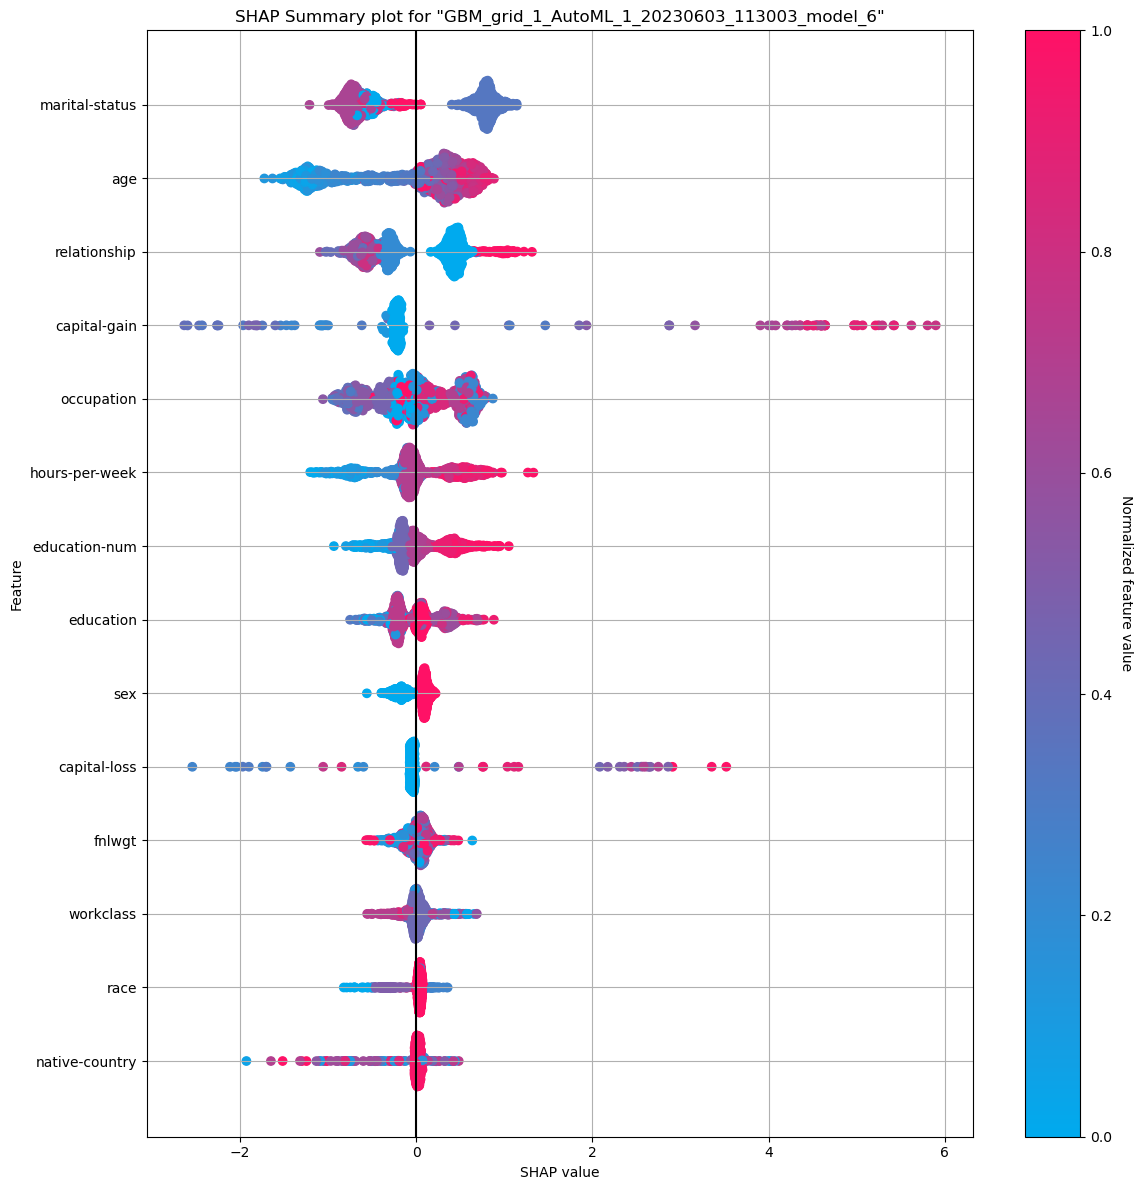

In [41]:
shap_plot = best_model.shap_summary_plot(valid)

ChatGPT says: SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

When using the `shap_summary_plot()` function in the `h2o` package, it's providing you with a SHAP summary plot, which is a standard way to visualize the SHAP values from a model. Here's what you're seeing:

- **Feature importance**: Variables are ordered by the sum of SHAP value magnitudes over all samples. The most important variable is at the top of the plot. This provides a view of global feature importance.

- **Impact**: The color represents the feature value (red high, blue low). This provides context as you can see whether high or low feature values attribute to positive or negative model output.

- **Original value**: Color shows whether that variable was high (in red) or low (in blue) for that observation.

- **Correlation**: A high positive SHAP value for a feature means that that feature was responsible for pushing the model's output higher (or lower). For example, if you see a group of points that have high SHAP value and are colored red, this could mean that a high value of that feature pushes the model output higher.

The x-axis indicates SHAP values, which demonstrate how much each feature changes the prediction as compared to the model's base output value (when no features are taken into account). Positive SHAP values push the prediction higher, while negative SHAP values push the prediction lower.

Each dot on the summary plot signifies an instance (or row) from the dataset. The y-axis lists all the features for which the SHAP values were computed.

To summarize, the SHAP summary plot provides a lot of information at once. You can see which features are most important, and also get a sense of their range, the directions of their effects (positive or negative), and the degree of that effect.

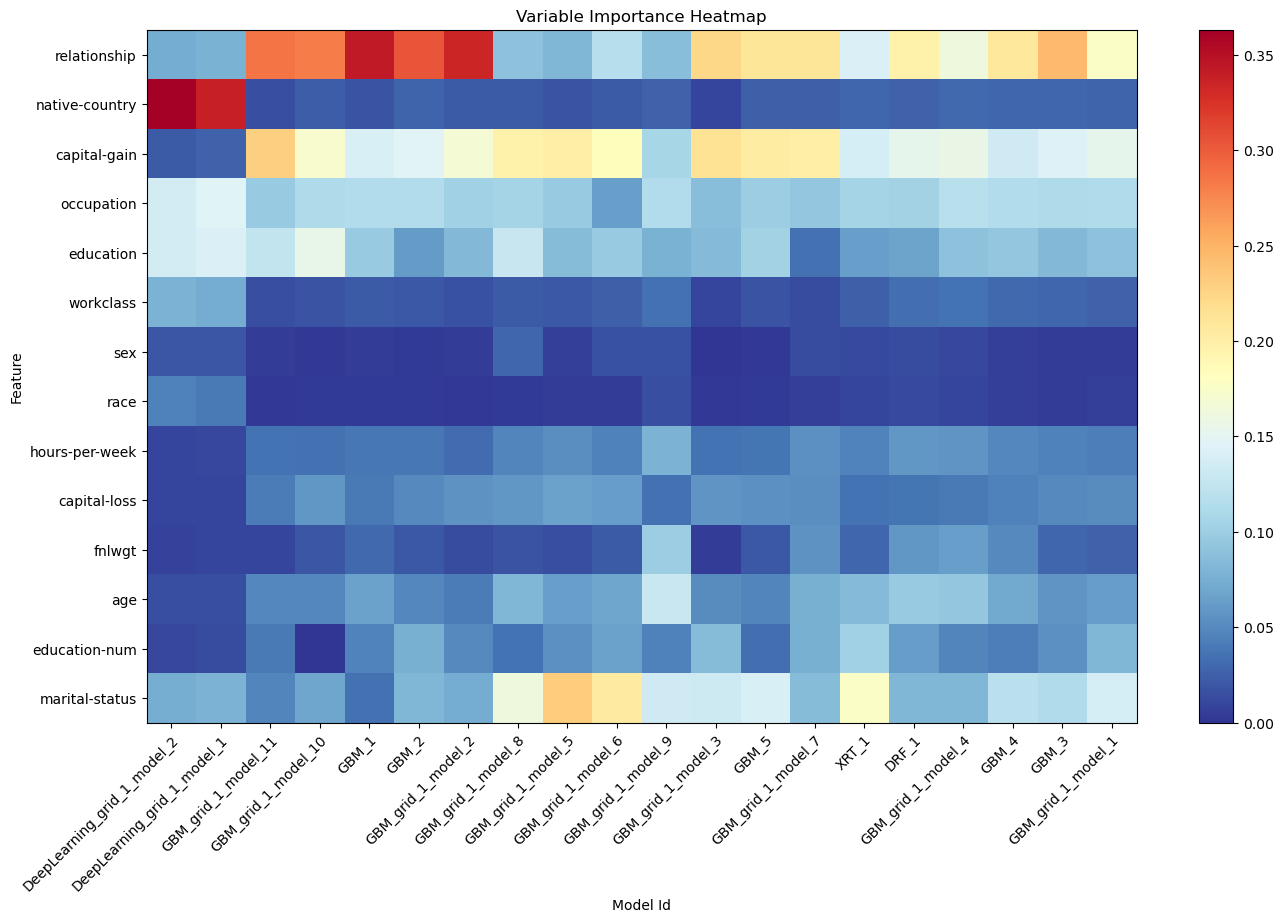

In [42]:
# or if some subset of the models is needed a slice of leaderboard can be used, e.g., using MAE as the sorting metric
va_plot = h2o.varimp_heatmap(aml.leaderboard.sort("aucpr", ascending=False).head(20))

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_grid_1_AutoML_1_20230603_113003_model_6

,0,1,Error,Rate
0,7199.0,665.0,0.0846,(665.0/7864.0)
1,653.0,1740.0,0.2729,(653.0/2393.0)
Total,7852.0,2405.0,0.1285,(1318.0/10257.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

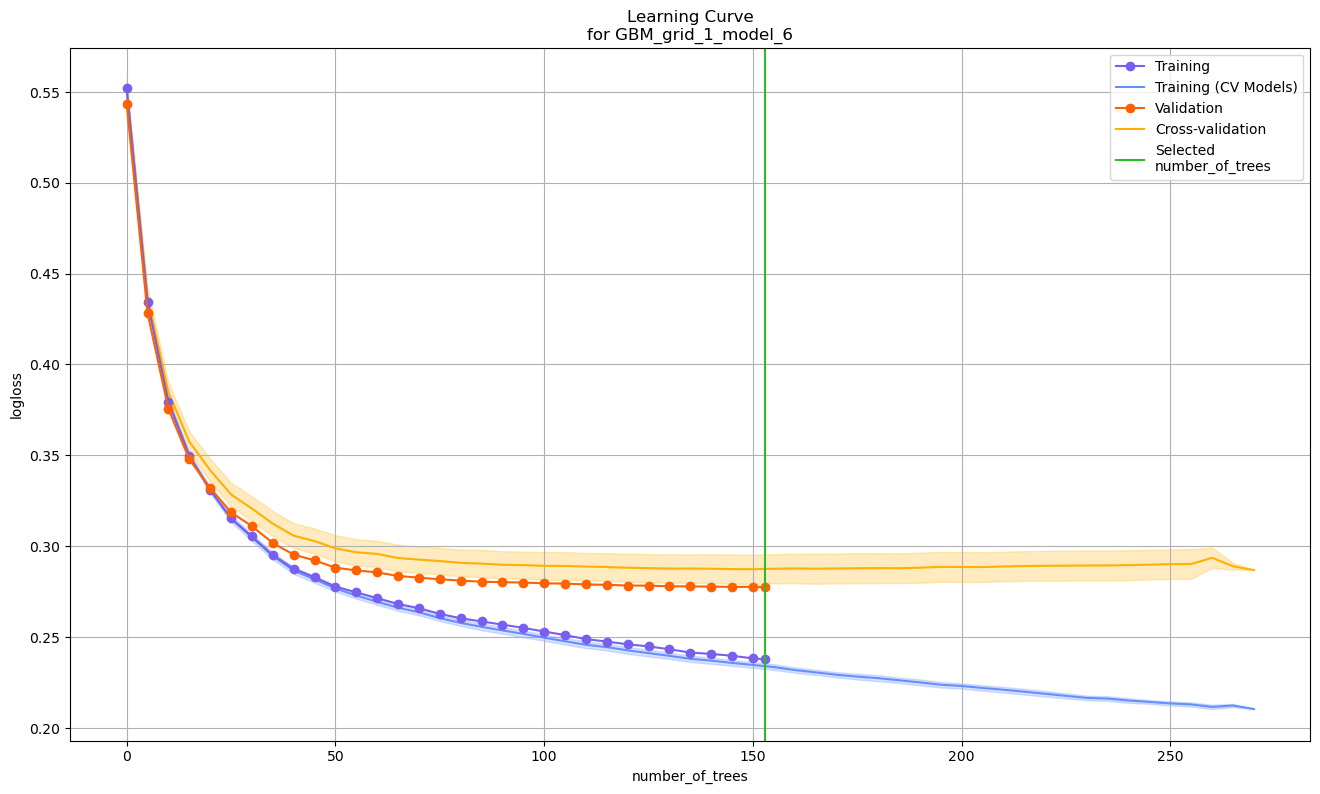

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

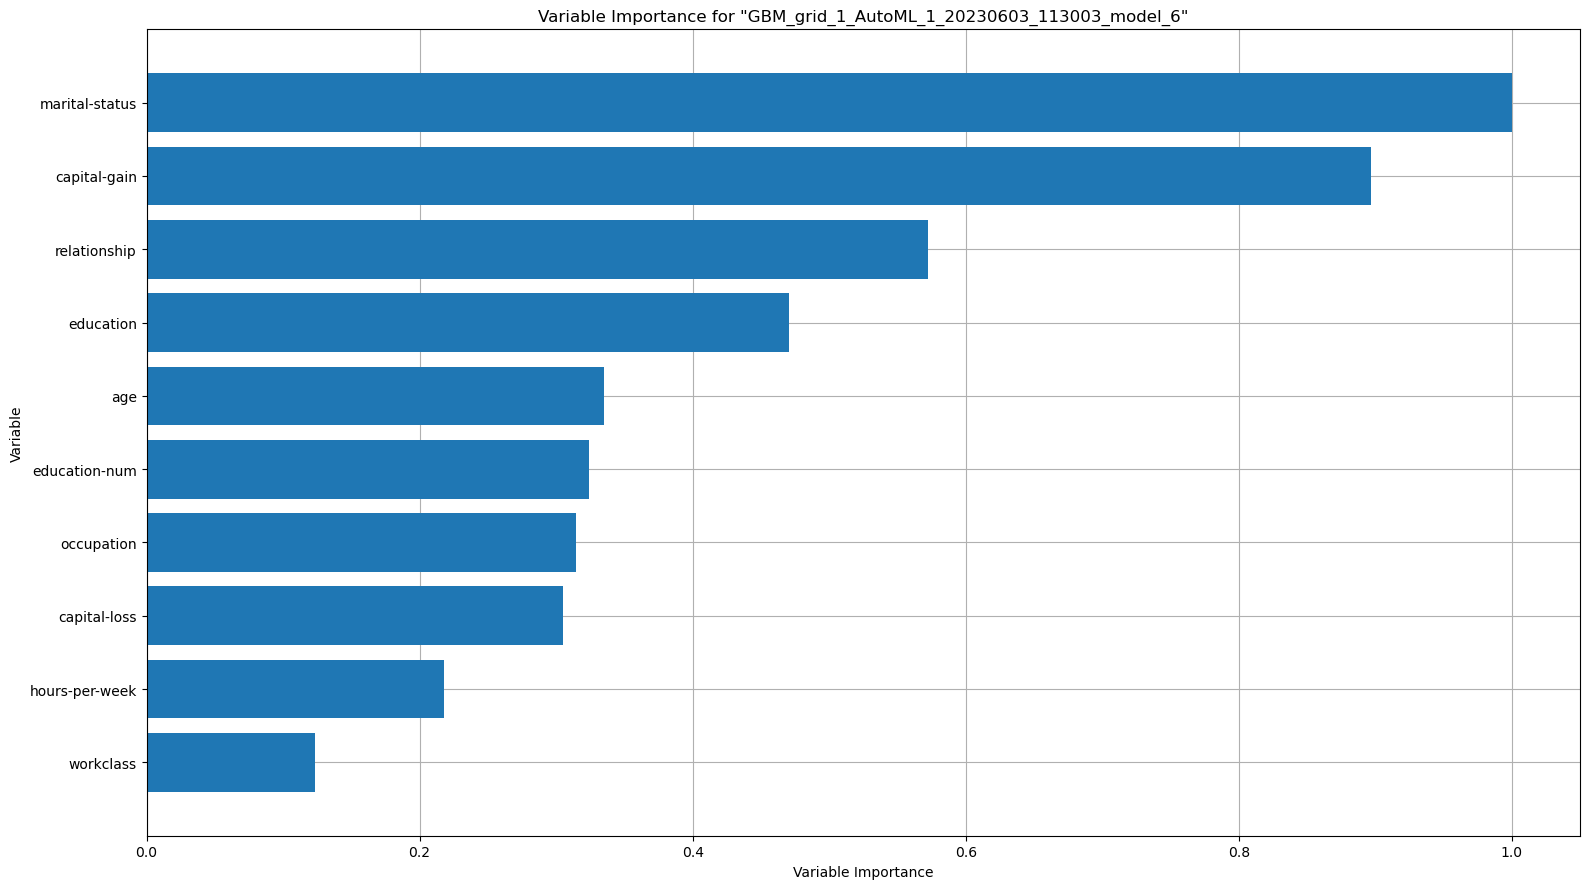

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

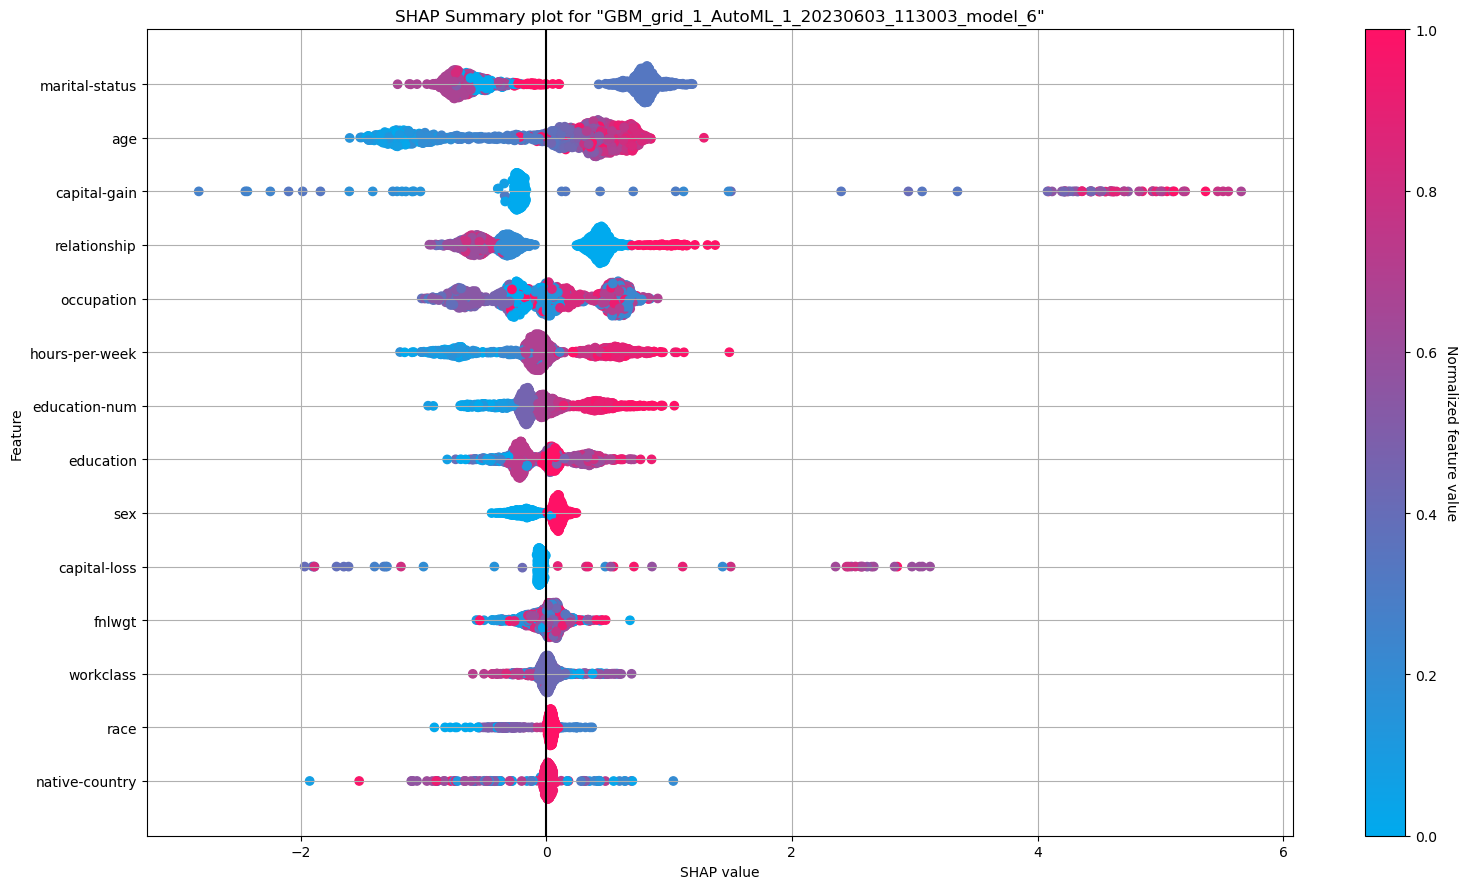

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

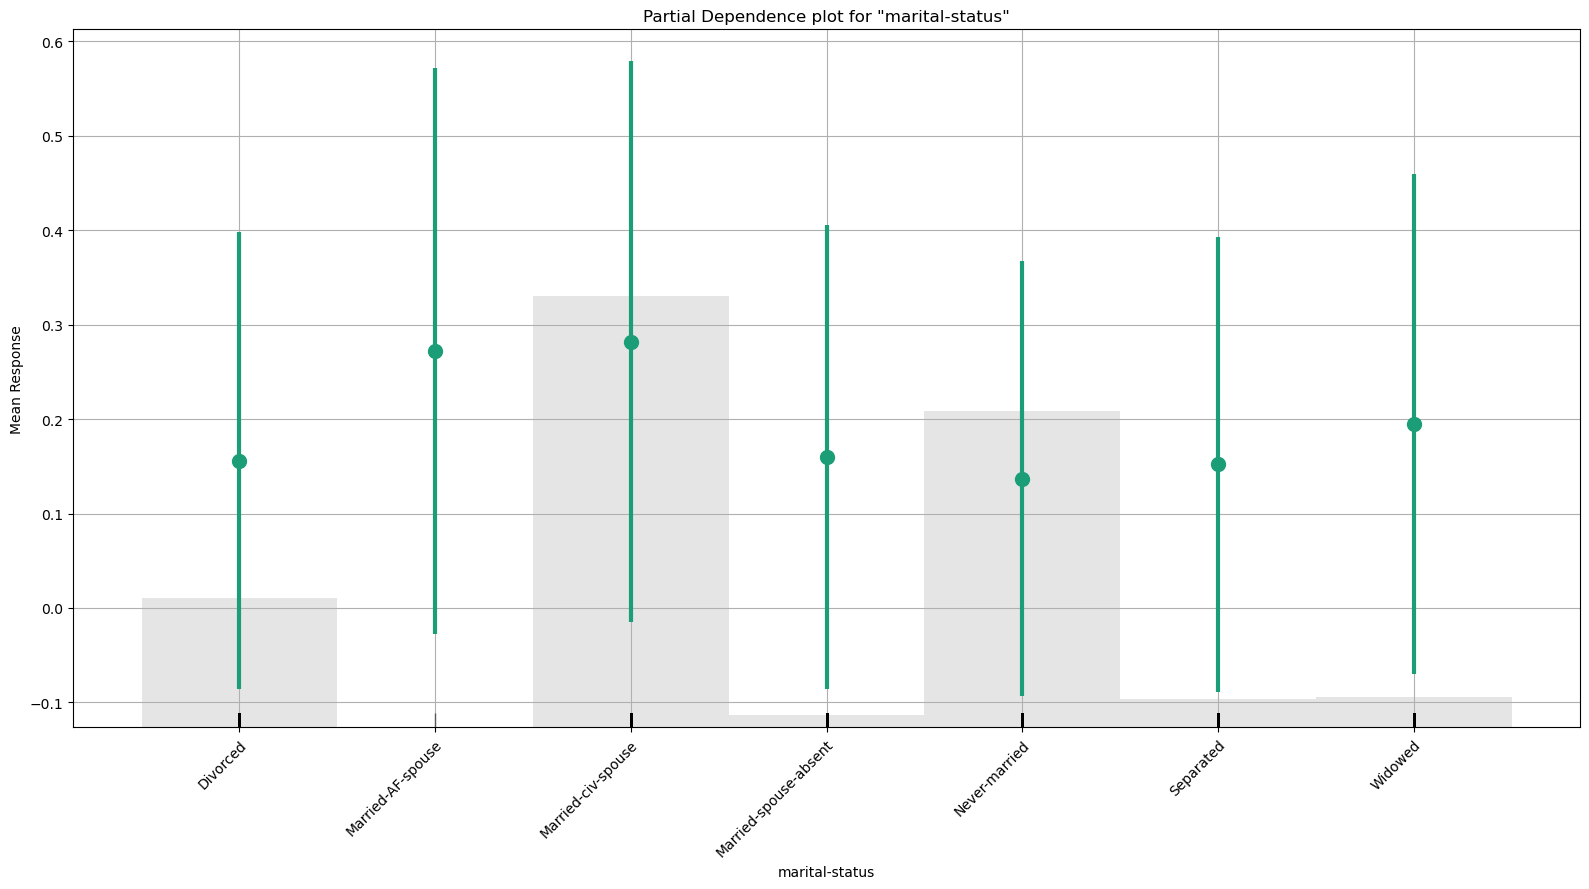

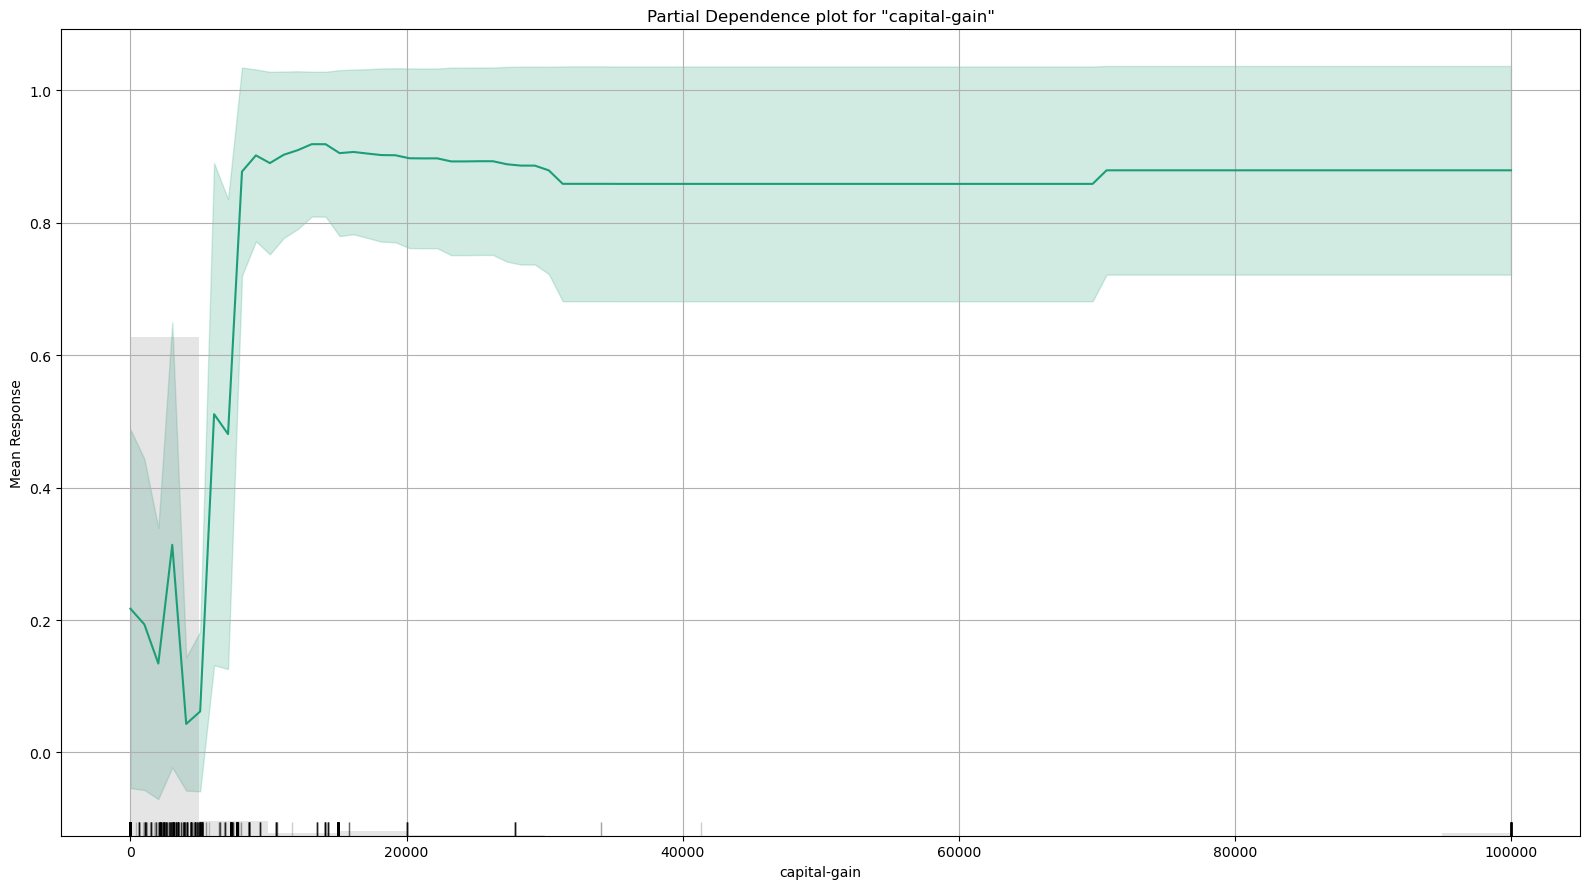

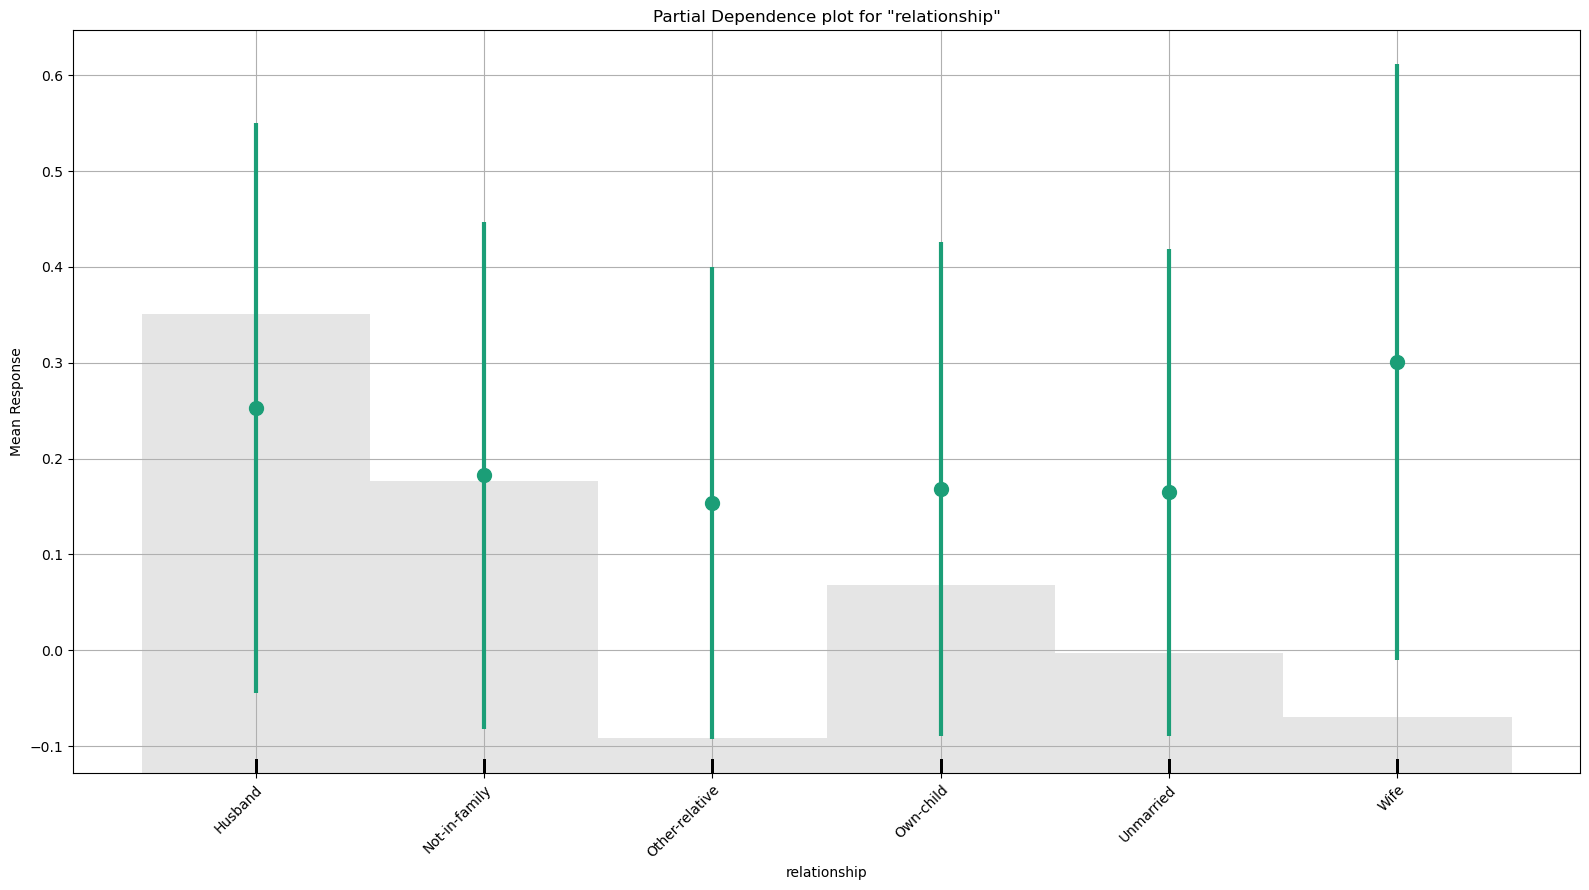

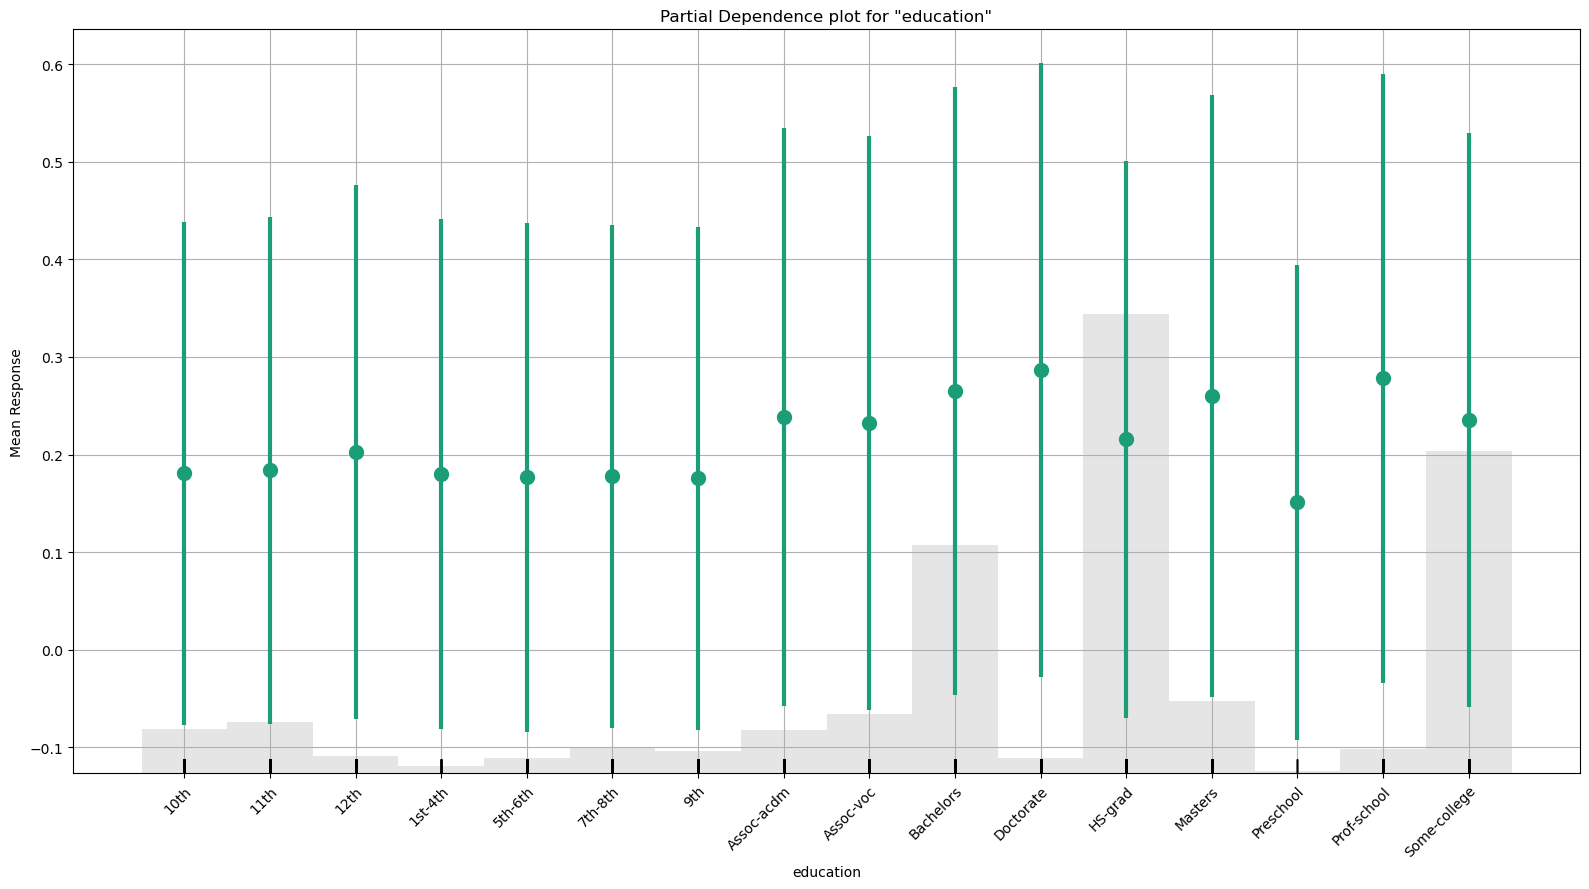

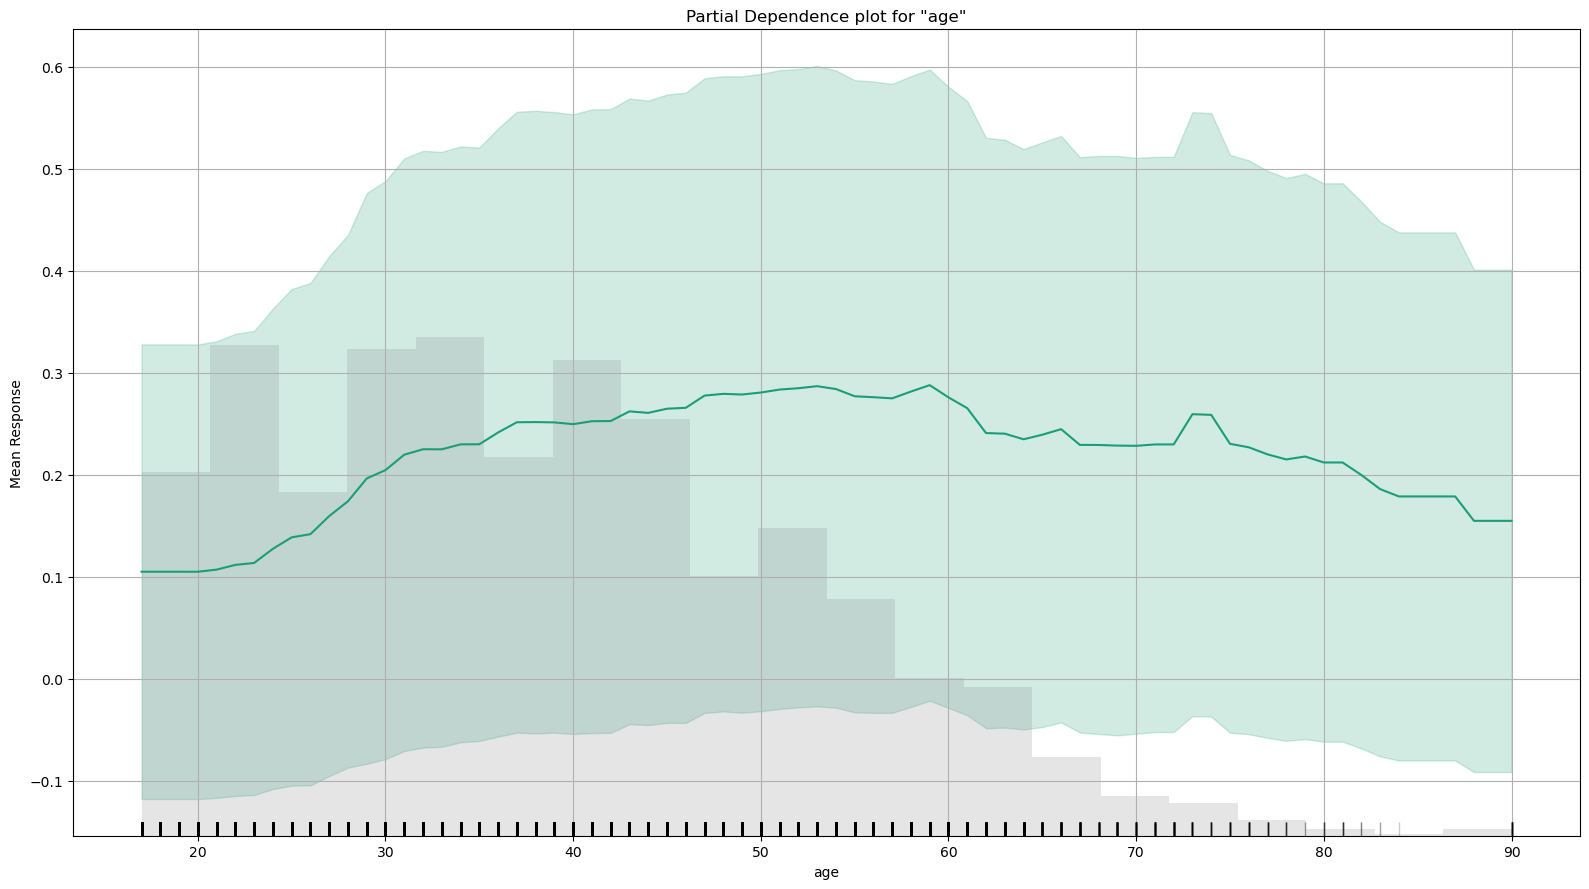

In [43]:
exm = best_model.explain(valid)

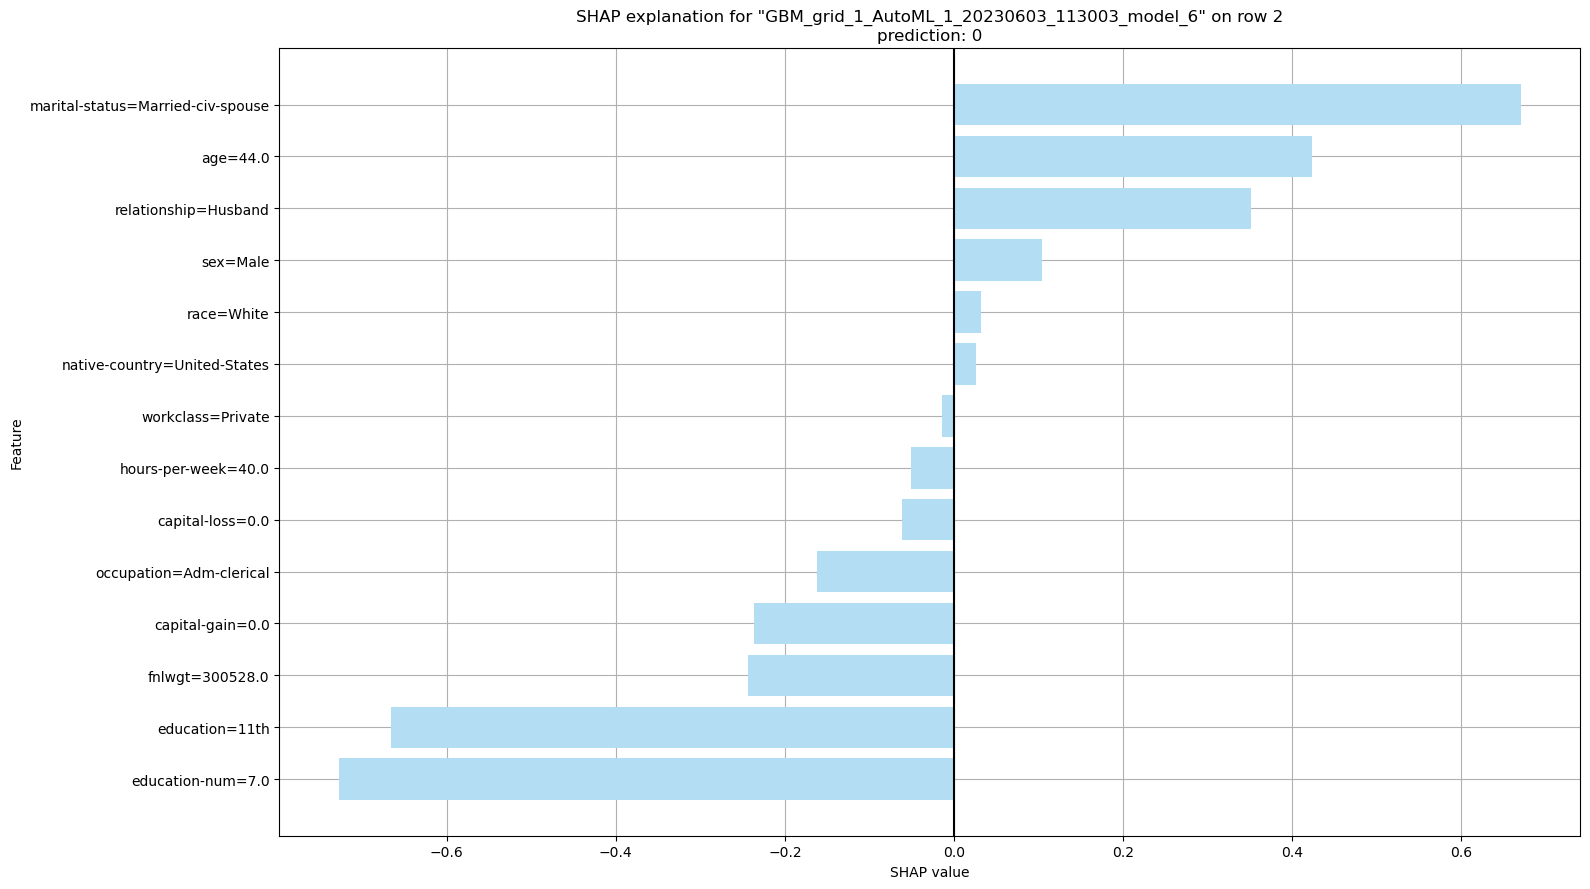

In [44]:
# explain a single line of a model
shapr_plot = best_model.shap_explain_row_plot(valid, row_index=2)

In [45]:
type(y_pred)

pandas.core.frame.DataFrame

## Apply the H2O.ai model with all the settings

this is to test if the model would actually work :-)

In [46]:
saved_mojo_model = h2o.import_mojo(var_path_model + var_model_name_full + "_model_stored.zip")

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


In [47]:
# re-import the stored features and column informations from the JSON file

import json

# Read the JSON file back into a Python dictionary
with open(var_path_model + var_model_name_full + "_variable_list.json", "r") as f:
    loaded_dict = json.load(f)

# fill the list of categorical columns
new_cat_cols = loaded_dict['cat_cols']
new_features = loaded_dict['features']

In [49]:
# in a real world scenario here you woudl provide the new data you want to score
# here we just use the test data from above

df_apply = h2o.H2OFrame(data_test.copy())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [50]:
# the prediction on the validation dataset will be brought back to KNIME
probabilities_df = saved_mojo_model.predict(df_apply).as_data_frame()

generic prediction progress: |███████████████████████████████████████████████████| (done) 100%


In [51]:
probabilities_df.head()

,predict,p0,p1
0,0,0.702275,0.297725
1,0,0.663116,0.336884
2,1,0.355872,0.644128
3,0,0.880676,0.119324
4,0,0.996983,0.003017


In [52]:
result = pd.concat([df_apply.as_data_frame(), probabilities_df], axis=1)

In [53]:
result.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Target,row_id,predict,p0,p1
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,Row0,0,0.702275,0.297725
1,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,Row1,0,0.663116,0.336884
2,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,1,Row2,1,0.355872,0.644128
3,32,Private,205019,Assoc-acdm,12,Never-married,Sales,Not-in-family,Black,Male,0,0,50,United-States,0,Row3,0,0.880676,0.119324
4,25,Self-emp-not-inc,176756,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,35,United-States,0,Row4,0,0.996983,0.003017


In [54]:
result.to_parquet(var_path_data + var_model_name_full + "_scored_test_data.parquet", compression='gzip')

In [55]:
# evaluate the best model on the test data
auc_pred = roc_auc_score(result['Target'], result['p1'], average='weighted')
print(f'Test AUC: {auc_pred:.4f}')

Test AUC: 0.9274


In [56]:
# from sklearn.metrics import average_precision_score
aucpr = average_precision_score(result['Target'], result['p1'], average='weighted', pos_label=1)
print(f'Test AUCPR: {aucpr:.4f}')

Test AUCPR: 0.8248


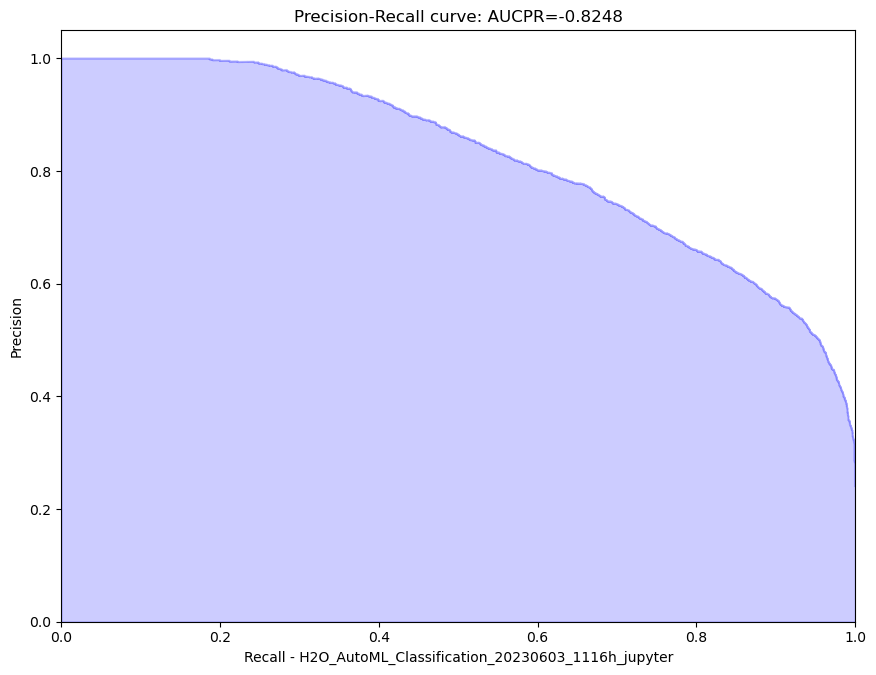

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = result["Target"].astype(int).values
y_score = result["p1"].values

precision, recall, thresholds = precision_recall_curve(y_true, y_score)
auc_pr = np.trapz(precision, recall)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall - ' + var_model_name_full)
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUCPR={0:0.4f}'.format(auc_pr))
plt.savefig(var_path_model + var_model_name_full + "_aucpr_plot.png")
plt.show()

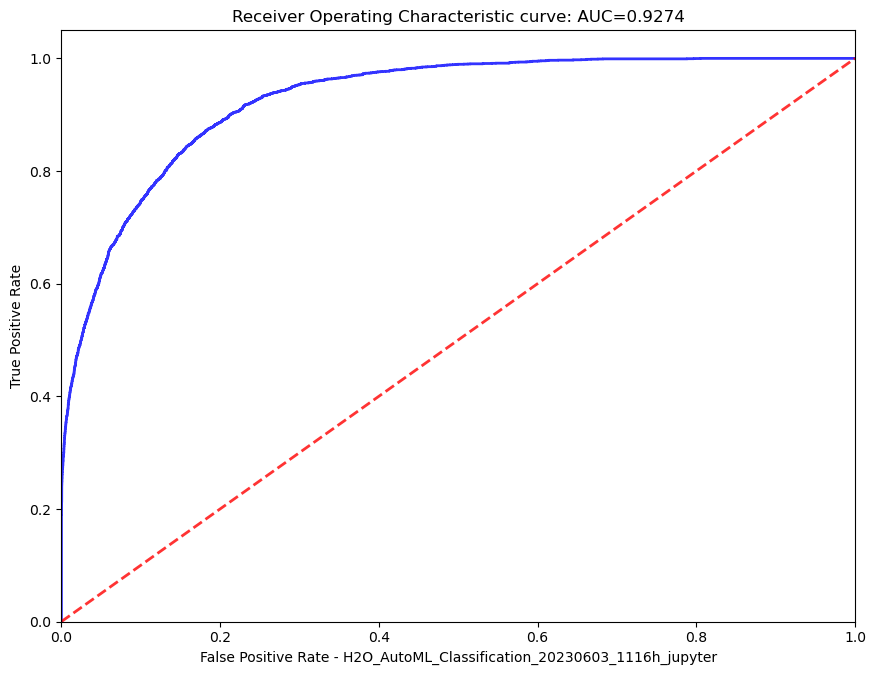

In [58]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
Ah y_true = result["Target"].astype(int).values
y_score = result["p1"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_roc = auc(fpr, tpr)

plt.tight_layout()
plt.gcf().set_size_inches(10.24, 7.68)
plt.plot(fpr, tpr, color='b', lw=2, alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
plt.xlabel('False Positive Rate - ' + var_model_name_full)
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Receiver Operating Characteristic curve: AUC={0:0.4f}'.format(auc_roc))
plt.savefig(var_path_model + var_model_name_full + "_auc_plot.png")
plt.show()